<a href="https://colab.research.google.com/github/czhangg17/Ciencia-de-Datos/blob/master/Covid_19_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import matplotlib.pylab as plt
from tensorflow import keras

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [0]:
from google.colab import drive
PATH = '/content/drive/My Drive/Mineria de datos/datosCovid.csv' 
drive.mount('/content/drive')
covid=pd.read_csv(PATH, header=0)
#print(covid)  
#covid=pd.read_excel(datosCovid.xlsx.csv)
covid.tail()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID de caso,Fecha de notificación,Codigo DIVIPOLA,Ciudad de ubicación,Departamento o Distrito,atención,Edad,Sexo,Tipo,Estado,País de procedencia,FIS,Fecha de muerte,Fecha diagnostico,Fecha recuperado,fecha reporte web,Tipo recuperación
43677,43718,2020-06-09T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Casa,52,M,En estudio,Asintomático,Colombia,Asintomático,NaN,2020-06-10T00:00:00.000,NaN,2020-06-10T00:00:00.000,- -
43678,43719,2020-06-09T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Casa,28,M,En estudio,Asintomático,Colombia,Asintomático,NaN,2020-06-10T00:00:00.000,NaN,2020-06-10T00:00:00.000,- -
43679,43720,2020-06-07T00:00:00.000,8001,Barranquilla,Barranquilla D.E.,Casa,78,F,En estudio,Leve,Colombia,2020-06-05T00:00:00.000,NaN,2020-06-10T00:00:00.000,NaN,2020-06-10T00:00:00.000,- -
43680,43721,2020-06-07T00:00:00.000,8001,Barranquilla,Barranquilla D.E.,Casa,28,M,En estudio,Leve,Colombia,2020-06-07T00:00:00.000,NaN,2020-06-10T00:00:00.000,NaN,2020-06-10T00:00:00.000,- -
43681,43722,2020-06-08T00:00:00.000,27001,Quibdó,Chocó,Hospital,63,F,En estudio,Moderado,Colombia,2020-06-01T00:00:00.000,NaN,2020-06-10T00:00:00.000,NaN,2020-06-10T00:00:00.000,- -


In [0]:
df=covid
df.describe()
#datos=df.iloc[:,1]
#casos diarios

#print(df_diarios)
#casos acumulados

#print(df_acumulados)

,ID de caso,Codigo DIVIPOLA,Edad
count,43682.000000,43682.000000,43682.000000
mean,21877.490454,28114.257864,38.890000
std,12616.302932,27486.582328,18.735272
min,1.000000,5.000000,0.000000
25%,10961.250000,11001.000000,26.000000
50%,21881.500000,11001.000000,36.000000
75%,32801.750000,50001.000000,51.000000
max,43722.000000,99001.000000,106.000000


In [0]:

df_diarios=pd.crosstab(df['Fecha de notificación'], columns='count')
df_acumulados=np.cumsum(df_diarios)

In [0]:
df_diarios.index=pd.to_datetime(df_diarios.index)
df_acumulados.index=pd.to_datetime(df_acumulados.index)
df_diarios.tail()

col_0,count
Fecha de notificación,
2020-06-06,636
2020-06-07,431
2020-06-08,301
2020-06-09,66
2020-06-10,21


Text(0.5, 1.0, 'Grafica Casos diarios en Colombia')

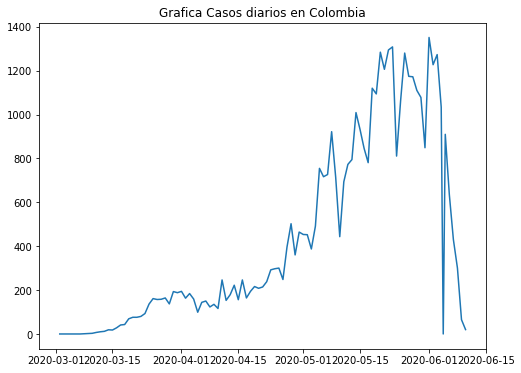

In [0]:
plt.plot(df_diarios)
plt.title('Grafica Casos diarios en Colombia')


Text(0.5, 1.0, 'Casos Acumulados en Colombia')

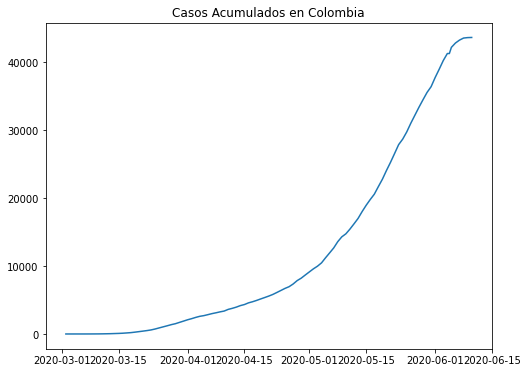

In [0]:
plt.plot(df_acumulados)
plt.title('Casos Acumulados en Colombia')

# Red LSTM con datos diarios


In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
TRAIN_SPLIT = int(len(df_diarios) * 0.8)
VAL_SPLIT=int(len(df_diarios) * 0.2)
print(TRAIN_SPLIT)


79


Reescalamiento de los datos

In [0]:
diarios=df_diarios.values
#diarios_mean=diarios[:TRAIN_SPLIT].mean()
#diarios_sd=diarios[:TRAIN_SPLIT].std()
#acumulados=df_acumulados.values
#acumulados_mean=acumulados[:TRAIN_SPLIT].mean()
#acumulados_sd=acumulados[:TRAIN_SPLIT].std()

In [0]:
#diarios=(diarios-diarios_mean)/diarios_sd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
diarios=scaler.fit_transform(diarios)


In [0]:
train_size = int(len(diarios) * 0.8)
test_size = len(diarios) - train_size
train, test = diarios[0:train_size], diarios[train_size:len(df)]
len_train = len(train)
len_test = len(test)
print(len_train, len_test)
#train=diarios[0:TRAIN_SPLIT]
#test=diarios[TRAIN_SPLIT:len(diarios)]
#print(test)

79 20


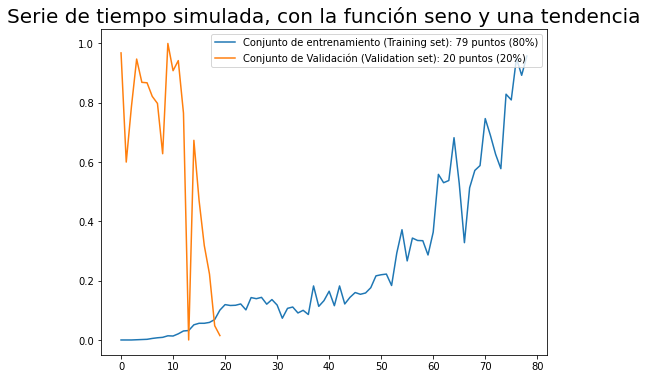

In [0]:

plt.plot(train, label='Conjunto de entrenamiento (Training set): ' + str(len_train) +' puntos (80%)')
plt.plot(test, label='Conjunto de Validación (Validation set): '  + str(len_test) + ' puntos (20%)') 
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend()
plt.show()

In [0]:
# aprendera con las 15 ultimas observaciones

univariate_past_history = 15
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(diarios, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(diarios, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [0]:
print ('Ventana  de la historia pasada')
print (x_train_uni[1])
print ('\n numero de casos objetivo (target) para predecir')
print (y_train_uni[1])

Ventana  de la historia pasada
[[0.        ]
 [0.        ]
 [0.00074074]
 [0.00148148]
 [0.00222222]
 [0.00518519]
 [0.00740741]
 [0.00888889]
 [0.01407407]
 [0.01333333]
 [0.02074074]
 [0.03037037]
 [0.03185185]
 [0.05111111]
 [0.0562963 ]]

 numero de casos objetivo (target) para predecir
[0.0562963]


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['Historia', 'Futuro Verdadero' , 'Predicción del Modelo']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Salto de tiempo (Time-Step)')
  return plt

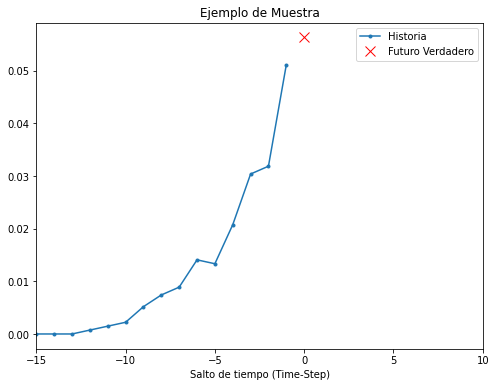

In [0]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Ejemplo de Muestra')
plt.show()

# modelo linea base

In [0]:
def baseline(history):
  return np.mean(history)

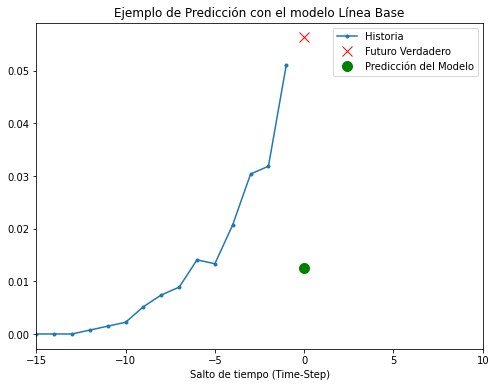

In [0]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Ejemplo de Predicción con el modelo Línea Base')
plt.show()

# RNN

In [0]:

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


In [0]:
#otro modelo pero usando 60 anteriores
lstm_output =60
model = keras.Sequential()
model.add(keras.layers.LSTM(units=lstm_output,  input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(keras.layers.Dense(units=1))

In [0]:
model.compile(loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001))

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60)                14880     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [0]:
for x, y in val_univariate.take(1):
    print(model.predict(x).shape)

(5, 1)


# entrenamiento del modelo

In [0]:
#entrenamiento del otro modelo
history = model.fit(
    x_train_uni, y_train_uni,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/30
4/4 [==============================] - 0s 95ms/step - loss: 0.0499 - val_loss: 0.3114
Epoch 2/30
4/4 [==============================] - 0s 14ms/step - loss: 0.0253 - val_loss: 0.1780
Epoch 3/30
4/4 [==============================] - 0s 14ms/step - loss: 0.0112 - val_loss: 0.0767
Epoch 4/30
4/4 [==============================] - 0s 14ms/step - loss: 0.0089 - val_loss: 0.0249
Epoch 5/30
4/4 [==============================] - 0s 14ms/step - loss: 0.0140 - val_loss: 0.0139
Epoch 6/30
4/4 [==============================] - 0s 14ms/step - loss: 0.0142 - val_loss: 0.0178
Epoch 7/30
4/4 [==============================] - 0s 19ms/step - loss: 0.0105 - val_loss: 0.0278
Epoch 8/30
4/4 [==============================] - 0s 17ms/step - loss: 0.0082 - val_loss: 0.0343
Epoch 9/30
4/4 [==============================] - 0s 15ms/step - loss: 0.0072 - val_loss: 0.0318
Epoch 10/30
4/4 [==============================] - 0s 14ms/step - loss: 0.0063 - val_loss: 0.0227
Epoch 11/30
4/4 [============

#Evaluacion

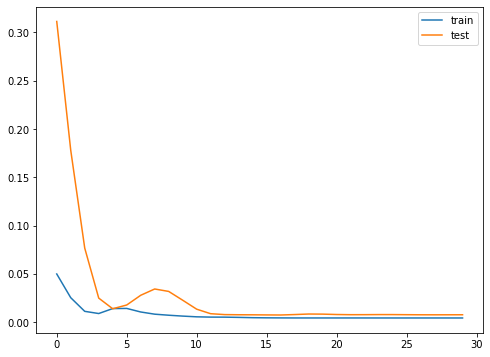

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

# prediccion del modelo LSTM

In [0]:
y_pred = model.predict(x_val_uni)

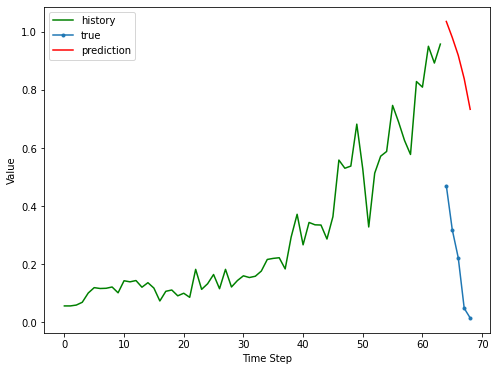

In [0]:
plt.plot(np.arange(0, len(y_train_uni)), y_train_uni, 'g', label="history")
plt.plot(np.arange(len(y_train_uni), len(y_train_uni) + len(y_val_uni)), y_val_uni, marker='.', label="true")
plt.plot(np.arange(len(y_train_uni), len(y_train_uni) + len(y_val_uni)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

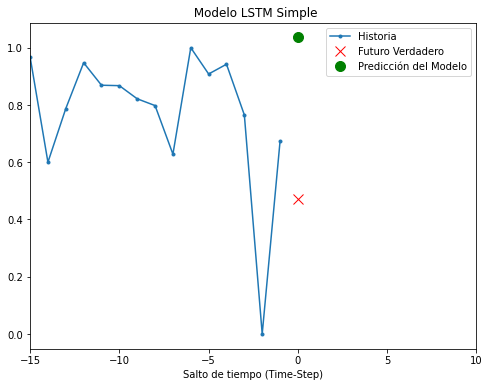

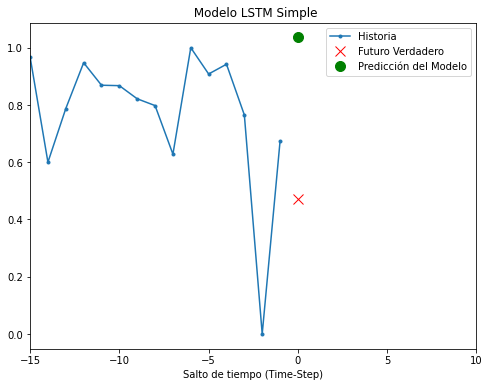

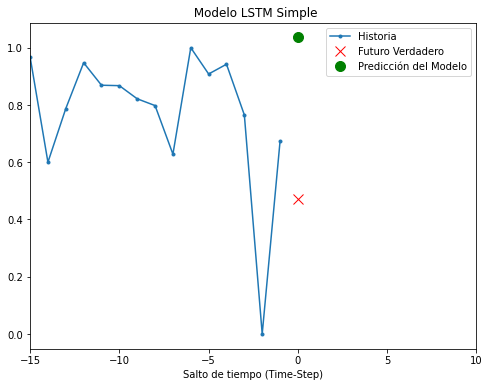

In [0]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 0, ' Modelo LSTM Simple')
  plot.show()
  

#quitando el resscalamiento


In [0]:
#pregunta por que no le quita el reescalamiento?
y_pred=scaler.inverse_transform(y_pred)
y_test=scaler.inverse_transform(y_val_uni.reshape(-1,1))


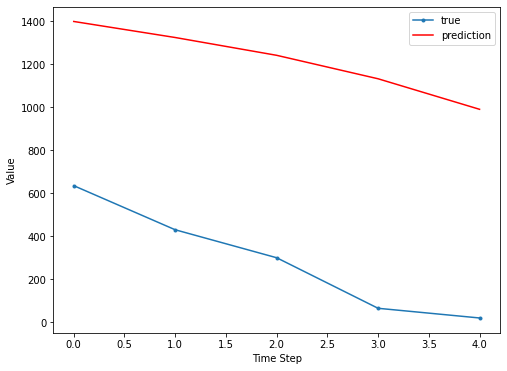

In [0]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Serie univariada con casos acumulados


In [0]:
acumulados=df_acumulados.values
#acumulados_mean=acumulados[:TRAIN_SPLIT].mean()
#acumulados_sd=acumulados[:TRAIN_SPLIT].std()
acumulados=scaler.fit_transform(acumulados)

TRAIN_SPLIT = int(len(acumulados) * 0.8)
VAL_SPLIT=int(len(acumulados) * 0.2)
print(TRAIN_SPLIT)

79


In [0]:
# reescalamiento de los datos con minmax
#acumulados=(acumulados-acumulados_mean)/acumulados_sd
# aprendera con las 15 ultimas observaciones

univariate_past_history = 15
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(acumulados, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(acumulados, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)


In [0]:
print ('Ventana  de la historia pasada')
print (x_train_uni[1])
print ('\n  objetivo (target) para predecir')
print (y_train_uni[1])

Ventana  de la historia pasada
[[2.28932488e-05]
 [4.57864976e-05]
 [9.15729951e-05]
 [1.60252741e-04]
 [2.51825737e-04]
 [4.34971727e-04]
 [6.86797463e-04]
 [9.84409698e-04]
 [1.44227467e-03]
 [1.87724640e-03]
 [2.54115061e-03]
 [3.50266706e-03]
 [4.50997001e-03]
 [6.11249742e-03]
 [7.87527758e-03]]

  objetivo (target) para predecir
[0.00963806]


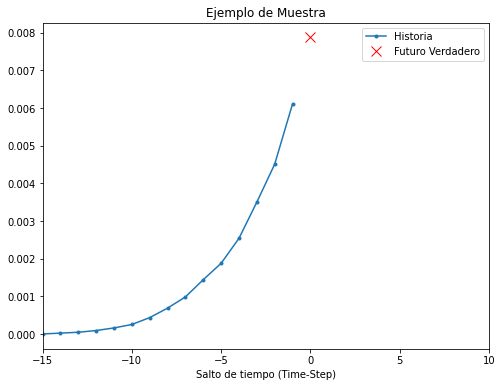

In [0]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Ejemplo de Muestra')
plt.show()

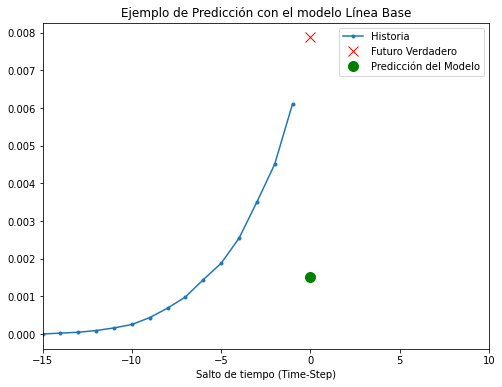

In [0]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Ejemplo de Predicción con el modelo Línea Base')
plt.show()

In [0]:
# compilacion del modelo
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
lstm_output =60
model = keras.Sequential()
model.add(keras.layers.LSTM(units=lstm_output,  input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(keras.layers.Dense(units=1))

In [0]:
#compilando el modelo
# compilacion del modelomodel.compile(loss='mean_squared_error',
model.compile(loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001))

In [0]:
history = model.fit(
    x_train_uni, y_train_uni,
    epochs=30,
    batch_size=16,
    validation_split=0.01,
    verbose=1,
    shuffle=False
)

Epoch 1/30
4/4 [==============================] - 0s 96ms/step - loss: 0.0305 - val_loss: 0.1858
Epoch 2/30
4/4 [==============================] - 0s 13ms/step - loss: 0.0161 - val_loss: 0.1129
Epoch 3/30
4/4 [==============================] - 0s 13ms/step - loss: 0.0078 - val_loss: 0.0578
Epoch 4/30
4/4 [==============================] - 0s 13ms/step - loss: 0.0049 - val_loss: 0.0241
Epoch 5/30
4/4 [==============================] - 0s 14ms/step - loss: 0.0055 - val_loss: 0.0101
Epoch 6/30
4/4 [==============================] - 0s 14ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 7/30
4/4 [==============================] - 0s 13ms/step - loss: 0.0042 - val_loss: 0.0084
Epoch 8/30
4/4 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0.0094
Epoch 9/30
4/4 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0076
Epoch 10/30
4/4 [==============================] - 0s 13ms/step - loss: 9.1956e-04 - val_loss: 0.0034
Epoch 11/30
4/4 [========

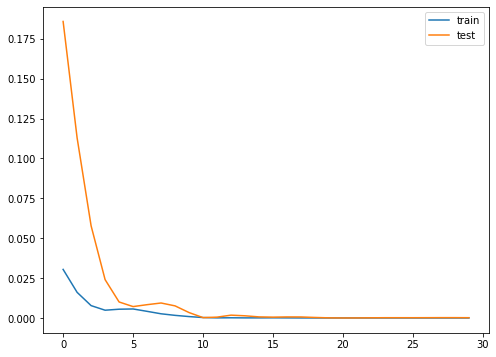

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

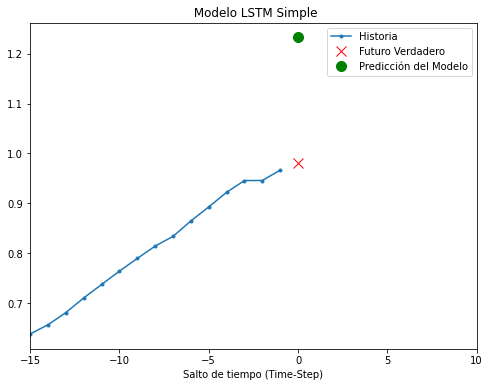

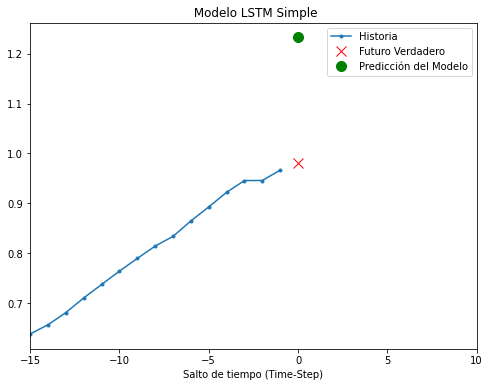

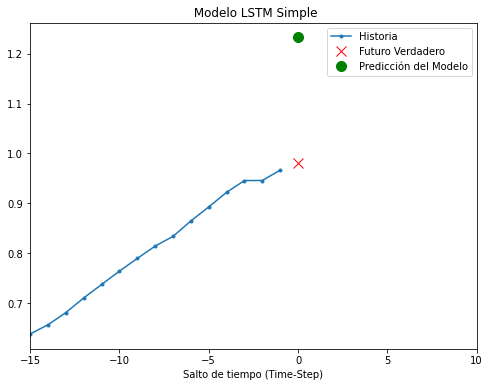

In [0]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 0, ' Modelo LSTM Simple')
  plot.show()
  

# Quitando en reescalamiento de los datos

In [0]:
y_pred = model.predict(x_val_uni)

In [0]:
#len(y_pred)

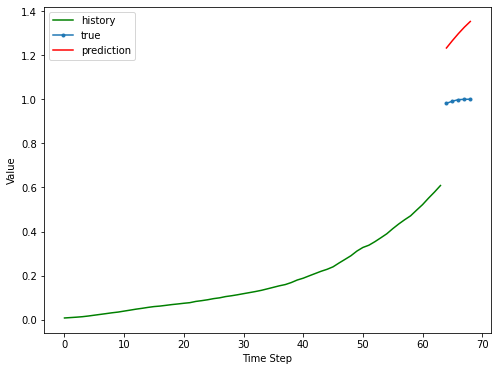

In [0]:
plt.plot(np.arange(0, len(y_train_uni)), y_train_uni, 'g', label="history")
plt.plot(np.arange(len(y_train_uni), len(y_train_uni) + len(y_val_uni)), y_val_uni, marker='.', label="true")
plt.plot(np.arange(len(y_train_uni), len(y_train_uni) + len(y_val_uni)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [0]:
#pregunta por que no le quita el reescalamiento?
y_pred=scaler.inverse_transform(y_pred)
y_test=scaler.inverse_transform(y_val_uni.reshape(-1,1))


ValueError: ignored

# Red LSTM  Multivariada



In [0]:
# Importamcion de datos para la parte multivariada
from google.colab import drive
drive.mount('/content/drive')
covid_multi=pd.read_excel('/content/drive/My Drive/Mineria de datos/COV.xlsx')
covid_multi.tail()
#llenar los na con 16000 y 16.500 los datos 95 y 96 en total recuperados


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,fecha,total_casos,total_muertes,total_recuperados
93,2020-06-06,36635,1145,14382
94,2020-06-07,38027,1205,15322
95,2020-06-08,39236,1259,16000
96,2020-06-09,40719,1308,16500
97,2020-06-10,42078,1372,16534


In [0]:

features_considered = ['total_casos','total_muertes','total_recuperados']

In [0]:
features = covid_multi[features_considered]
features.index = covid_multi['fecha']
features.head()

,total_casos,total_muertes,total_recuperados
fecha,,,
2020-03-02,0,0,0
2020-03-06,0,0,0
2020-03-07,1,0,0
2020-03-08,0,0,0
2020-03-09,0,0,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc633609a90>,
      dtype=object)

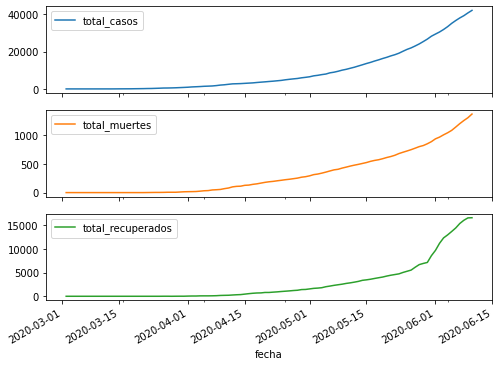

In [0]:
features.plot(subplots=True)


In [0]:
dataset = features.values

len_train=int(len(dataset)* 0.8)
len_test=int(len(dataset)*0.2)
data_mean = dataset[:len_train].mean(axis=0)
data_std = dataset[:len_train].std(axis=0)

In [0]:
print(len_train,len_test)

78 19


#Reescalamiento de los datos

In [0]:
#dataset = (dataset-data_mean)/data_std
TRAIN_SPLIT=int(len(dataset)*0.8)
VAL_SPLIT =int(len(dataset) *0.2)
print(TRAIN_SPLIT,VAL_SPLIT)

78 19


In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

## modelo a un paso

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 15
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [0]:
x_train_single.shape 
x_val_single.shape
y_val_single.shape

(5,)

In [0]:
BATCH_SIZE=6 # 6 Lotes de 3 filas o registros 
BUFFER_SIZE=100

In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

train_data_single
val_data_single

<RepeatDataset shapes: ((None, 15, 3), (None,)), types: (tf.int64, tf.int64)>

In [0]:
print(val_data_single)

<RepeatDataset shapes: ((None, 15, 3), (None,)), types: (tf.int64, tf.int64)>


In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(15,input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

In [0]:
#otra forma de crear el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=STEP, return_sequences=True, input_shape=(x_train.shape[1],1)),
    tf.keras.layers.LSTM(units=STEP),
    tf.keras.layers.Dense(1)])

In [0]:
#compilacion del otro modelo
model.compile(loss='mse', optimizer='adam')

In [0]:
x_train_single.shape[-2:]

(15, 3)

# compilacion del modelo

In [0]:
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')

In [0]:
EPOCHS=30
EVALUATION_INTERVAL=1
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=1)

Epoch 1/30
1/1 [==============================] - 0s 10ms/step - loss: 105704.5859 - val_loss: 1587902.6250
Epoch 2/30
1/1 [==============================] - 0s 10ms/step - loss: 67373.0547 - val_loss: 1587892.1250
Epoch 3/30
1/1 [==============================] - 0s 11ms/step - loss: 28308.4062 - val_loss: 1587879.2500
Epoch 4/30
1/1 [==============================] - 0s 11ms/step - loss: 87689.8984 - val_loss: 1587856.8750
Epoch 5/30
1/1 [==============================] - 0s 10ms/step - loss: 139276.1875 - val_loss: 1587835.7500
Epoch 6/30
1/1 [==============================] - 0s 10ms/step - loss: 65545.5547 - val_loss: 1587821.3750
Epoch 7/30
1/1 [==============================] - 0s 10ms/step - loss: 85304.8203 - val_loss: 1587805.1250
Epoch 8/30
1/1 [==============================] - 0s 10ms/step - loss: 147520.3906 - val_loss: 1587783.8750
Epoch 9/30
1/1 [==============================] - 0s 10ms/step - loss: 25569.3691 - val_loss: 1587775.7500
Epoch 10/30
1/1 [=================

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

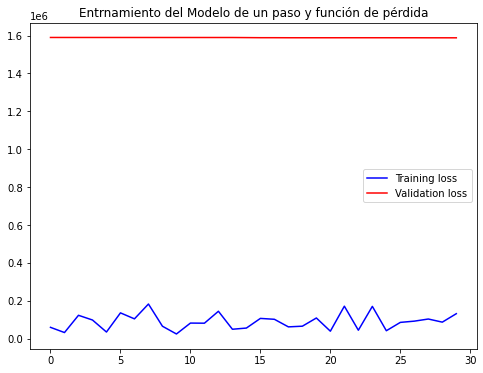

In [0]:
plot_train_history(single_step_history,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

In [0]:
single_step_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 15)                1140      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 16        
Total params: 1,156
Trainable params: 1,156
Non-trainable params: 0
_________________________________________________________________


In [0]:
#inputs = dataset[len_data - len_valid - time_step:].values
#inputs = inputs.reshape(-1,1)
#inputs  = scaler.transform(inputs)

#x_test = []
#for i in range(time_step,inputs.shape[0]):
#    x_test.append(inputs[i-time_step:i,0])
#x_test = np.array(x_test)
#x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

#prediccion a un paso

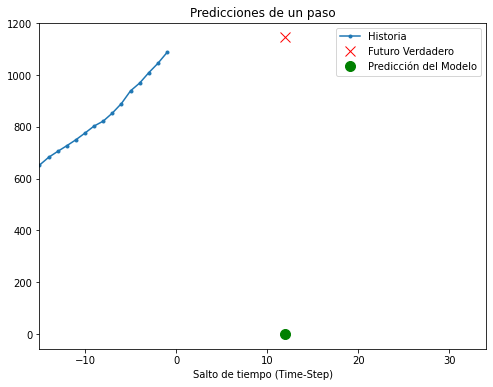

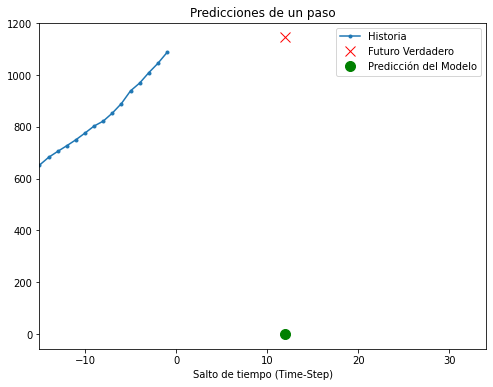

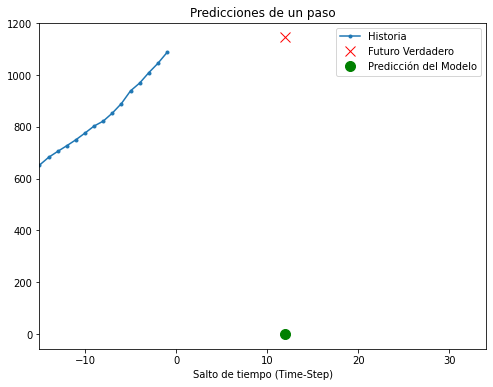

In [0]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Predicciones de un paso')
  plot.show()

# siguiendo otro script
https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/